# Wind Power Forecasting: Design Phase (Part 2)

In this lab you will compare different forecasting techniques to **predict the power output of one turbine for the next 24 hours**. Note that this process could be replicated for all the turbines to predict the total power output of your wind farm. This lab uses the Tensorflow framework for making forecasts and draws inspiration from their [official guide](https://www.tensorflow.org/tutorials/structured_data/time_series) on time series forecasting, so go check it out if you are interested in understanding more about how the code works.

The steps you will take in this lab are:

1. Import Python packages
2. Load the dataset
3. Slice your data and resample to an hourly frequency
4. Split your data into train, validation, and test sets
5. Establish a baseline \
    5.1 Make random predictions \
    5.2 Replicate the last 24 hours (tomorrow == today) \
    5.3 Compute a moving average 
6. Visualize a time series of your target and predictors
7. Train neural network models using historical data \
    7.1 Look at example input and output sequences \
    7.2 Train a neural network using only the history of the target \
    7.3 Train a neural network using the history of all features 
8. Include wind speed forecasts in your model \
    8.1 Neural network model with perfect wind speed forecasts \
    8.2 Generate "synthetic" wind speed forecasts \
    8.3 Neural network model with synthetic wind speed forecasts 

## 1. Import Python packages.

Run the next cell to import that Python packages you'll need for this lab.

Note the `import utils` line. This line imports the functions that were specifically written for this lab. If you want to look at what these functions are, go to `File -> Open...` and open the `utils.py` file to have a look.

In [1]:
import pandas as pd # package for reading in and manipulating the data
import utils # utility functions for this lab

print('All packages imported successfully!')

All packages imported successfully!


## 2. Load the dataset

Run the next cell to load your dataset. You will use the data you curated during the previous lab which only includes the top 10 turbines in terms of power output, and where you have performed feature engineering and added a column to identify abnormal values, which will be skipped by the models you train in the upcoming sections.

In [2]:
# Load the data into a pandas dataframe
curated_data = pd.read_csv("data/wind_data.csv")

# Print out the turbines that are included in the dataset
print(f'Turbines included in the dataset: {curated_data.TurbID.unique()}')

curated_data.head(5)

Turbines included in the dataset: [ 1  3  4  5  6  9 10 11 12 70]


,Datetime,TurbID,Wspd,Etmp,Itmp,Prtv,Patv,Include,WdirCos,WdirSin,NdirCos,NdirSin,PabCos,PabSin
0,2020-05-01 00:00:00,1,NaN,NaN,NaN,NaN,0.00,False,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-01 00:10:00,1,6.17,30.73,41.80,-0.25,494.66,True,0.997576,-0.069582,0.899405,0.437116,0.999848,0.017452
2,2020-05-01 00:20:00,1,6.27,30.60,41.63,-0.24,509.76,True,0.999276,-0.038039,0.934142,0.356901,0.999848,0.017452
3,2020-05-01 00:30:00,1,6.42,30.52,41.52,-0.26,542.53,True,0.999919,-0.012741,0.934142,0.356901,0.999848,0.017452
4,2020-05-01 00:40:00,1,6.25,30.49,41.38,-0.23,509.36,True,0.999879,0.015533,0.934142,0.356901,0.999848,0.017452


## 3. Slice your data and resample to an hourly frequency

With this next step, you'll select just one turbine to train and test your models, but you can change the `turb_id` parameter below to replicate the same process for any of the top ten turbines to get the power output for each, and in principle, you could extend this process to the entire wind farm.

Here you'll also reduce the cadence of the data by sampling at hourly intervals (down from 10 min intervals in the original data).

Run the next cell to prepare your data for the forecasting process. 

In [3]:
# Select the turbine you will use
turb_id = 6

# Prepare data for feeding into the network
data = utils.prepare_data(curated_data, turb_id)

data.head(5)

,Wspd,Etmp,Itmp,Prtv,WdirCos,WdirSin,NdirCos,NdirSin,PabCos,PabSin,Patv
Datetime,,,,,,,,,,,
2020-05-01 00:50:00,6.37,30.77,37.90,-0.10,0.999397,-0.034725,0.530955,0.847400,1.000000,0.000524,501.54
2020-05-01 01:50:00,6.92,30.04,37.13,-0.06,0.989751,-0.142802,0.530955,0.847400,1.000000,0.000349,502.57
2020-05-01 02:50:00,7.16,29.98,36.89,-0.13,0.983064,-0.183265,0.701904,0.712271,0.999693,0.024781,513.08
2020-05-01 03:50:00,7.44,30.00,36.62,-0.09,0.996285,-0.086112,0.819152,0.573576,0.999479,0.032283,629.92
2020-05-01 04:50:00,9.58,30.24,35.71,-0.14,0.999693,-0.024781,0.839146,0.543907,0.982935,0.183951,458.30


## 4. Split your data into train, validation, and test sets

Now that you have prepared your data for modeling you will split it into three categories: `training`, `validation` and `testing`. You don't need to worry about the specific details here but the idea is that you will use the `training` portion of your data later to train your neural network models and the `validation` portion of your data to know when to stop training your model. Then you'll assess its performance using the `testing` portion (which is data that the model has not seen during testing and validation). Also, all of the features you use will be normalized, which means that they are converted to a similar scale, this helps the network to converge faster.

Run the next cell to create train, validation, and test sets and normalize your data.

In [4]:
# Split the data into training, validation and testing
data_splits = utils.train_val_test_split(data)

print("training, validation and testing splits successfully created and normalized.")

training, validation and testing splits successfully created and normalized.


## 5. Establish a baseline

With your data ready, you will see different forecasting techniques in action, starting by three baselines that you can use to compare with the models you will train.

### 5.1. Random predictions

You will begin with a simple baseline which consists of predicting random power values drawn from previous days.


Mean Absolute Error (kW): 380.79 for forecast.

Improvement over random baseline: 0.00%


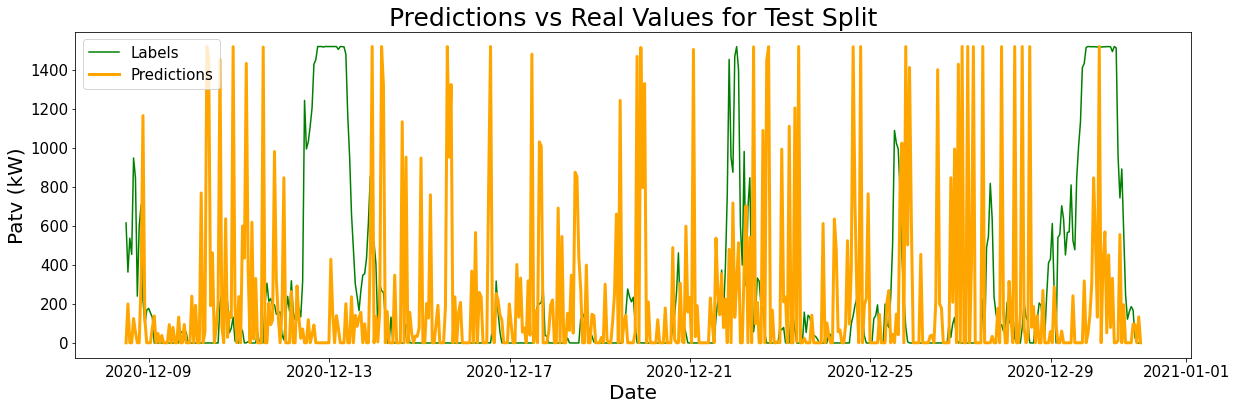

In [5]:
# Compute the random baseline
random_window, random_baseline = utils.random_forecast(data_splits)

# Plot the predicted vs real values for the test split
random_baseline_mae = random_window.plot_long(random_baseline, data_splits)

### 5.2. Replicate the last 24 hours (tomorrow == today)

Now you will implement another simple baseline which consists of using the previous day to predict the next one, but not in any clever way, just saying "I predict tomorrow's wind power output will be the same as today". 

The next cell performs this computation and shows a plot of actual vs predicted values along with some performance metrics. Note that the slider is set to 24 hours in the future, but you can change it to predict for earlier times (in other words you can say for example: "I predict the power output in 17 hours to be the same as now").

In [6]:
# Create a model by predicting the next 24 hours of wind power will be the same as the previous 24 hours
utils.interact_repeat_forecast(data_splits, baseline_mae=random_baseline_mae)

interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

### 5.3. Compute a moving average

The next baseline you'll investigate is a moving average and consists of averaging the last `n_days` to obtain a prediction for a future value. For this baseline you can select the time horizon into the future that you want to predict so at any given time step if you select 1 hour into the future you will use the previous 24 hours to predict the next hour. If you select 15 hours into the future you will use the previous 24 hours to generate the value for 15 hours into the future. Here you can also change the `n_days` parameter in the code to include a longer past period into the average.

In [7]:
# Compute the baseline (try changing the n_days parameter)
moving_avg_window, moving_avg_baseline = utils.moving_avg_forecast(data_splits, n_days=1)

# Plot the predicted vs real values for the test split
utils.prediction_plot(moving_avg_window.plot_long, moving_avg_baseline, data_splits, baseline_mae=random_baseline_mae)

interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

## 6. Visualize a time series of your target and predictors

For the baseline models above, you've been operating on the test set of data you created. Now, you'll use the training and validations sets to develop neural network models and then evaluate them on that same test set to see how they compare to your baselines. 

Before performing the actual model training you'll visualize how your train, validation, and test sets look for your target variable, which is `Patv` or active power, and your feature variables. 

When you run the next cell, your target, `Patv` will appear in the top plot and you can use the pulldown menu to plot any of the feature variables in the bottom plot. Notice that abnormal values are omitted so you can see where they occur.

In [8]:
# Generate time series plot showing train, validation, and test data
utils.plot_time_series(data_splits)

interactive(children=(Dropdown(description='Feature', options=('Wspd', 'Etmp', 'Itmp', 'Prtv', 'WdirCos', 'Wdi…

## 7. Train neural network models using historical data


### 7.1. Look at example input and output sequences

Next, you will train a model that learns patterns in the data in order to make predictions, or more specifically, a model that attempts to learn from the past to predict the future. For this particular lab, you are interested in predicting the power output for the next 24 hours into the future. 

When you run the next cell, you are not doing any predictions yet. You will visualize how it would look to use different amounts of past data to predict 24 hours into the future.

For example, using the slider to choose `"Days before = 1"` will show you an example of using input data 24 hours into the past to train a model that predicts energy output 24 hours into the future. Note that the data here is for demonstration purpose and not an actual prediction. You can move the `Days before` slider to visualize what it would look like to use different "windows" into the past in order to predict the future, where your window size can range from 1 to 14 days. Notice that you will get random batches of data every time you move the slider.

In [9]:
# Plot input and output sequences
utils.window_plot(data_splits)

interactive(children=(IntSlider(value=1, continuous_update=False, description='Days before', layout=Layout(wid…

### 7.2. Train a neural network using only the target's history
With this first iteration of modeling, you will try to predict the future of power output using only the history of the power output, or in other words, given knowledge of the power output over some number of days in the past, your model will attempt to predict the power output over the next 24 hours. 

The number of days in the past that will be used to generate a future prediction is set to 1 by default but you can change this (the `days_in_past` variable below) to another value to see how that changes things. 


You will use a technique called `single shot prediction`, which means that for every time step you will generate predictions of the next 24 hours. In the visualization below, you can use this output to look at what your result would be if you were attempting to use historical patterns to predict anywhere from one hour to 24 hours into the future. 

Run the next cell to train a neural network to predict the power output in the future given only information about the power output in the past. 

In [10]:
# Only using the target without any other predictors
features = ["Patv"]

# Compute the forecasts
window, model, _data_splits = utils.train_conv_lstm_model(data, features, days_in_past=1)

# Plot the predicted vs real values for the test split
utils.prediction_plot(window.plot_long, model, _data_splits, baseline_mae=random_baseline_mae)

Epoch 1/20
128/128 [==============================] - 8s 24ms/step - loss: 0.9044 - val_loss: 0.9741
Epoch 2/20
128/128 [==============================] - 2s 14ms/step - loss: 0.8676 - val_loss: 0.9701
Epoch 3/20
128/128 [==============================] - 2s 13ms/step - loss: 0.8650 - val_loss: 0.9738
Epoch 4/20
128/128 [==============================] - 2s 13ms/step - loss: 0.8634 - val_loss: 0.9759

Training stopped early to prevent overfitting, as the validation loss is increasing for two consecutive steps.


interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

### 7.3. Train a neural network using all the features history

Now you will use the same model as before but including the history of all of the features in your dataset. The visualization is the same, where you can compare your results for using historical data to predict from one hour up to 24 hours into the future.

In [11]:
# Now using all features
features = list(data.columns)

# Compute the forecasts
window, model, _data_splits = utils.train_conv_lstm_model(data, features, days_in_past=1)

# Plot the predicted vs real values for the test split
utils.prediction_plot(window.plot_long, model, _data_splits, baseline_mae=random_baseline_mae)

Epoch 1/20
128/128 [==============================] - 8s 25ms/step - loss: 0.8871 - val_loss: 0.9520
Epoch 2/20
128/128 [==============================] - 2s 14ms/step - loss: 0.8394 - val_loss: 0.9557
Epoch 3/20
128/128 [==============================] - 2s 14ms/step - loss: 0.8261 - val_loss: 0.9318
Epoch 4/20
128/128 [==============================] - 2s 13ms/step - loss: 0.8183 - val_loss: 0.9687
Epoch 5/20
128/128 [==============================] - 2s 14ms/step - loss: 0.8133 - val_loss: 0.9714

Training stopped early to prevent overfitting, as the validation loss is increasing for two consecutive steps.


interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

## 8. Include wind speed forecasts in your model

So far you have only used historical data to try to predict future values. It turns out that doesn't work very well.

There were no weather forecasts included in the original SDWPF competition dataset, but in a real world wind power forecasting scenario, you would certainly have forecasts to include in your modeling as well. 

In this case, you can create "synthetic" wind forecasts by simply including the next day's wind data in your set of predictors that previously only included historical data. Of course, this is unrealistic because you will never have perfect knowledge of what the wind will do in the future, but let's look at this as a first step before trying to create a more realistic representation of a wind speed forecast.
 

### 8.1 Train a neural network model using perfect wind speed forecasts

Run the next cell to look at how your results would change if you had perfect wind speed forecasts by including the next 24 hours of wind speed data in your set of predictors.

In [12]:
# Create a new dataframe with the perfect forecasts
data_with_perfect_wspd_forecasts = utils.add_wind_speed_forecasts(data)

# Include all features along with the external forecasts
features = list(data_with_perfect_wspd_forecasts.columns)

# Compute the power output forecasts
window, model, _data_splits = utils.train_conv_lstm_model(data_with_perfect_wspd_forecasts, features, days_in_past=1)

# Plot the predicted vs actual values for the test split
utils.prediction_plot(window.plot_long, model, _data_splits, baseline_mae=random_baseline_mae)

Epoch 1/20
128/128 [==============================] - 8s 25ms/step - loss: 0.6203 - val_loss: 0.3665
Epoch 2/20
128/128 [==============================] - 2s 14ms/step - loss: 0.3430 - val_loss: 0.3113
Epoch 3/20
128/128 [==============================] - 2s 14ms/step - loss: 0.2943 - val_loss: 0.3010
Epoch 4/20
128/128 [==============================] - 2s 14ms/step - loss: 0.2630 - val_loss: 0.3096
Epoch 5/20
128/128 [==============================] - 2s 14ms/step - loss: 0.2407 - val_loss: 0.2820
Epoch 6/20
128/128 [==============================] - 2s 14ms/step - loss: 0.2229 - val_loss: 0.2829
Epoch 7/20
128/128 [==============================] - 2s 14ms/step - loss: 0.2077 - val_loss: 0.2686
Epoch 8/20
128/128 [==============================] - 2s 15ms/step - loss: 0.1953 - val_loss: 0.2702
Epoch 9/20
128/128 [==============================] - 2s 15ms/step - loss: 0.1874 - val_loss: 0.2563
Epoch 10/20
128/128 [==============================] - 2s 14ms/step - loss: 0.1802 - val_lo

interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

### 8.2 Generate "synthetic" wind speed forecasts

To generate synthetic wind speed forecasts, you'll use an analysis of actual wind forecasts and measured values for three different cities taken from Open Weather's [5 day weather forecast API](https://openweathermap.org/forecast5). 

The location of the wind farm that produced the SDWPF dataset was not disclosed by the competition organizers, so you will use these forecasts from around the world to get a feeling of how much the weather forecast differs from the actual wind speed.

In [13]:
# Load the data
weather_forecasts = utils.load_weather_forecast()

# Plot measured wind speed and forecasts for different periods into the future
utils.plot_forecast(weather_forecasts)

interactive(children=(Dropdown(description='City', options=('Geelong, Australia', 'Porto Alegre, Brazil', 'Pit…

To understand how the forecast degrades as you try to predict further into the future, run the next cell to plot the `Mean Absolute Error` of the predicted vs. actual wind speed values from one to 120 hours into the future:

In [14]:
# Plot wind speed error as a function of hours into the future for different locations
utils.plot_mae_forecast(weather_forecasts)

interactive(children=(Dropdown(description='City', options=('Geelong, Australia', 'Porto Alegre, Brazil', 'Pit…

Now you're ready to generate synthetic wind forecasts! 

Run the cell below to create a synthetic forecast, by adding random noise to it. Then plot it to compare the actual wind measurements with synthetic forecasts with a different amount of noise added. Use the slider to add more or less noise to the wind data. Compare the MAE with the MAE from real forecasts in the plot above.

In [15]:
# Create a new dataframe with the forecasts
data_with_wspd_forecasts = utils.add_wind_speed_forecasts(data, add_noise="linearly_increasing")

utils.plot_forecast_with_noise(data_with_wspd_forecasts)

interactive(children=(IntSlider(value=1, continuous_update=False, description='Noise level in m/s (low to high…

### 8.3 Train a neural network model using synthetic wind speed forecasts

Now instead of using a "perfect" weather forecast, you can use a more realistic one to train the neural network and predict the generated power. Run the cell below to see how well it works.

In [16]:
# Create a new dataframe with the external forecasts
data_with_wspd_forecasts = utils.add_wind_speed_forecasts(data, add_noise="mimic_real_forecast")

# Include all features along with the external forecasts
features = list(data_with_wspd_forecasts.columns)

# Compute the forecasts
window, model, _data_splits = utils.train_conv_lstm_model(data_with_wspd_forecasts, features, days_in_past=1)

# Plot the predicted vs real values for the test split
utils.prediction_plot(window.plot_long, model, _data_splits, baseline_mae=random_baseline_mae)

Epoch 1/20
128/128 [==============================] - 8s 26ms/step - loss: 0.6836 - val_loss: 0.4857
Epoch 2/20
128/128 [==============================] - 2s 14ms/step - loss: 0.4171 - val_loss: 0.3923
Epoch 3/20
128/128 [==============================] - 2s 15ms/step - loss: 0.3302 - val_loss: 0.3050
Epoch 4/20
128/128 [==============================] - 2s 15ms/step - loss: 0.2851 - val_loss: 0.3138
Epoch 5/20
128/128 [==============================] - 2s 14ms/step - loss: 0.2588 - val_loss: 0.2888
Epoch 6/20
128/128 [==============================] - 2s 14ms/step - loss: 0.2400 - val_loss: 0.3003
Epoch 7/20
128/128 [==============================] - 2s 14ms/step - loss: 0.2281 - val_loss: 0.2716
Epoch 8/20
128/128 [==============================] - 2s 14ms/step - loss: 0.2126 - val_loss: 0.2897
Epoch 9/20
128/128 [==============================] - 2s 14ms/step - loss: 0.2015 - val_loss: 0.2810

Training stopped early to prevent overfitting, as the validation loss is increasing for tw

interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

## **Congratulations on finishing this lab!**

**Keep up the good work :)**